In [49]:
import tensorflow as tf
import importlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from datetime import datetime
import utils_optim
import model1
import results_generator
importlib.reload(utils_optim)
importlib.reload(model1)
importlib.reload(results_generator)
from utils_optim import *
from model1 import *
from results_generator import *
tf.test.is_built_with_cuda()

True

In [ ]:
# This code is only needed if the dataset is stored in google drive
from google.colab import drive
drive.mount('/content/gdrive')

In [29]:
# Check if gpu exists
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# This code is only needed if the dataset is stored in google drive and it is 7z compressed
!p7zip -d /content/gdrive/MyDrive/Thesis/Sketch-Icon-Dataset.7z

In [19]:
icon_name_category, sketch_name_category = get_icons_and_sketches()

In [20]:
positive_pairs = positive_pairs_generator(icon_name_category, sketch_name_category)
positive_pairs = shuffle(positive_pairs)

len_data = len(positive_pairs)
p_train=0.9
p_test=0.1
num_train = int(np.ceil(len_data*p_train))
num_test = int(np.floor(len_data*p_test))

positive_pairs_Train = positive_pairs[:num_train]
possible_negative_pairs_Train = possible_negative_pairs_generator(positive_pairs_Train, icon_name_category)

positive_pairs_Test = positive_pairs[-num_test:]
sketches_Test = positive_pairs_Test[:, [0, 1]]

icons_Test = positive_pairs_Test[:, [2, 3]]
# create the icons test dataset by removing the dublicates of the array
_, unique_indices = np.unique(icons_Test[:,0], return_index=True)
unique_icons_Test = icons_Test[unique_indices]

print(f'We have {len(triplet_pairs_Train)} samples in the training set.')
print(f'We have {len(sketches_Test)} sketches in the test set.')
print(f'We have {len(unique_icons_Test)} unique icons in the test set.')

We have 28626 samples in the training set.
We have 3180 sketches in the test set.
We have 1115 unique icons in the test set.


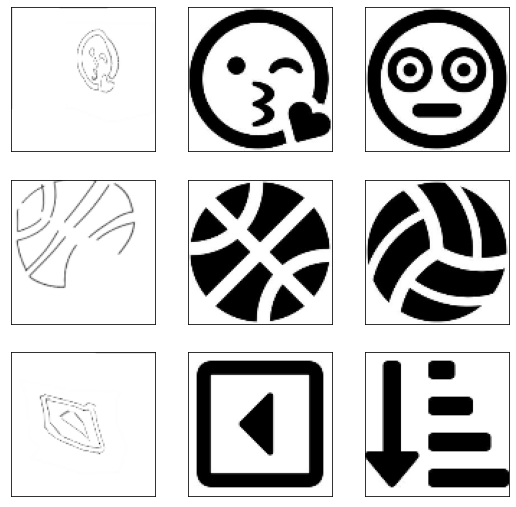

In [57]:
BATCH_SIZE = 128
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (100, 100))
    return image

def preprocess_triplets(sketch, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(sketch),
        preprocess_image(positive),
        preprocess_image(negative),
    )

def preprocess_images(images):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return preprocess_image(images)
    

def generate_Train_dataset(positive_pairs_Train, icon_name_category, possible_negative_pairs_Train, BATCH_SIZE):
    triplet_pairs_Train = triplets_generator(positive_pairs_Train, icon_name_category, possible_negative_pairs_Train)
    triplet_pairs_Train = shuffle(triplet_pairs_Train)

    sketches_Train, positive_icons_Train, negative_icons_Train = triplet_path_generator(triplet_pairs_Train)
    sketches_dataset = tf.data.Dataset.from_tensor_slices(sketches_Train)
    positive_dataset = tf.data.Dataset.from_tensor_slices(positive_icons_Train)
    negative_dataset = tf.data.Dataset.from_tensor_slices(negative_icons_Train)

    train_dataset = tf.data.Dataset.zip((sketches_dataset, positive_dataset, negative_dataset))
    train_dataset = train_dataset.cache()
    train_dataset = train_dataset.shuffle(buffer_size=1024)
    train_dataset = train_dataset.map(preprocess_triplets, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return train_dataset

def generate_Test_sets(sketches_Test, icons_Test, BATCH_SIZE):
    sketches_paths_Test, icons_paths_Test = path_generator(sketches_Test, icons_Test)

    sketches_dataset = tf.data.Dataset.from_tensor_slices(sketches_paths_Test)
    sketches_dataset = sketches_dataset.cache()
    sketches_dataset = sketches_dataset.shuffle(buffer_size=1024)
    sketches_dataset = sketches_dataset.map(preprocess_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    sketches_dataset = sketches_dataset.batch(BATCH_SIZE, drop_remainder=False)
    sketches_dataset = sketches_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    icons_dataset = tf.data.Dataset.from_tensor_slices(icons_paths_Test)
    icons_dataset = icons_dataset.cache()
    icons_dataset = icons_dataset.shuffle(buffer_size=1024)
    icons_dataset = icons_dataset.map(preprocess_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    icons_dataset = icons_dataset.batch(BATCH_SIZE, drop_remainder=False)
    icons_dataset = icons_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return sketches_dataset, icons_dataset

def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])
train_dataset = generate_Train_dataset(positive_pairs_Train, icon_name_category, possible_negative_pairs_Train, BATCH_SIZE)

sketch_dataset_Test, icon_dataset_Test = generate_Test_sets(sketches_Test, unique_icons_Test, BATCH_SIZE)

visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [60]:
num_epochs = 1000
margin = 1
learning_rate = 0.0001
choice = 0

# Initializations of optimizer, loss and network and set the backend (model variables) to float32
optimizer = tf.keras.optimizers.Adam(learning_rate)
tf.keras.backend.set_floatx('float32')
tripleModel = mynet()
loss = triplet_loss

# Function which is responsible to calculate the loss and update the grads
def train_step(sketches, positive_icons, negative_icons, margin):
    with tf.GradientTape() as tape:
        sketch_features,_ = tripleModel(sketches, training = True)
        icon_positive_features,_ = tripleModel(positive_icons, training = True) 
        icon_negative_features,_ = tripleModel(negative_icons, training = True)   
        tape.watch(sketch_features)
        tape.watch(icon_positive_features)
        tape.watch(icon_negative_features)
        current_loss = loss(sketch_features, icon_positive_features, icon_negative_features, margin)
    grads = tape.gradient(current_loss, tripleModel.trainable_variables)
    optimizer.apply_gradients((grad, var) for (grad, var) in zip(grads, tripleModel.trainable_variables) if grad is not None)
    return current_loss

In [61]:
import time
top_acc = 0
top_acc1 = 0
top_acc10 = 0

for epoch in range(num_epochs):

    # Training loop throught the training dataset
    epoch_loss_avg = tf.keras.metrics.Mean()
    start_time = time. time()
    for sketches, positive_icons, negative_icons in train_dataset:
        loss_value = train_step(sketches, positive_icons, negative_icons, margin)
        epoch_loss_avg.update_state(loss_value)
    print("Epoch {:d}: Loss: {:.3f}".format(epoch,epoch_loss_avg.result()))

    if epoch%1==0:
      # Test loop through the test datatet
        acc_1 = 0
        acc_10 = 0

        # extract features for sketches
        sketch_representations = []
        for batch_sketches in sketch_dataset_Test:
            if choice == 0:
              sketch_repr,_ =  tripleModel(batch_sketches, training = False)
            elif choice == 1:
              sketch_repr,_ =  sketchClassificationModel(sketches_array, training = False)
            sketch_representations.append(sketch_repr)
        sketch_representations = np.vstack(sketch_representations)

        # extract features for icons
        icon_representations = []
        for batch_icons in icon_dataset_Test:
            if choice == 0:
              icons_repr,_ =  tripleModel(batch_icons, training = False)
            elif choice == 1:
              icons_repr,_ =  iconClassificationModel(icons_array, training = False)
            icon_representations.append(icons_repr)
        icon_representations = np.vstack(icon_representations)

        # check using euclidean distance the top 1 and top 10 accuracy
        for k in range(len(sketch_representations)):
            sketch_repr = sketch_representations[k]
            sketch_representations_tile = np.tile(sketch_repr, len(unique_icons_Test)).reshape(len(unique_icons_Test), 64)
            diff = np.sqrt(np.mean((sketch_representations_tile - icon_representations)**2, -1))
            top_k = np.argsort(diff)[:10]
            
            for j in range(len(top_k)):
                index = top_k[j]
                if j == 0 and sketches_Test[k][0].split("_")[0] == unique_icons_Test[index][0].replace(".jpg",""):
                    acc_1 = acc_1 + 1
                    acc_10 = acc_10 + 1
                    break
                elif sketches_Test[k][0].split("_")[0] == unique_icons_Test[index][0].replace(".jpg",""):
                    acc_10 = acc_10 + 1
                    break
        if top_acc < acc_1 + acc_10:
          #if choice == 0:
           # save_weights(tripleModel, train_weights_path + "/TripletWithCWI")
          #elif choice == 1:
           # save_weights(iconClassificationModel, train_weights_path + "/iconTripletWithCWI")
            #save_weights(sketchClassificationModel, train_weights_path + "/sketchTripletWithCWI")
          top_acc = acc_1 + acc_10
          top_acc1 = acc_1
          top_acc10 = acc_10
        print("Accuracy of top 1: " + str(acc_1/len(sketches_Test)))
        print("Accuracy of top 10: " + str(acc_10/len(sketches_Test)))
        #write_triplet_stats_in_file(current_run_path, epoch, epoch_loss_avg.result(), acc_1/len(sketches_Test), acc_10/len(sketches_Test))

    train_dataset = generate_Train_dataset(positive_pairs_Train, icon_name_category, possible_negative_pairs_Train, BATCH_SIZE)
    current_time = time. time()
    elapsed_time = current_time - start_time
    print("Finished iterating in: " + str(int(elapsed_time)) + " seconds")

Epoch 0: Loss: 483.802
Accuracy of top 1: 0.0009433962264150943
Accuracy of top 10: 0.010377358490566037
Finished iterating in: 258 seconds
Epoch 1: Loss: 184.611
Accuracy of top 1: 0.0009433962264150943
Accuracy of top 10: 0.010691823899371069
Finished iterating in: 257 seconds


KeyboardInterrupt: 